In [1]:
!pip install tensorflow keras torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load Dataset
df = pd.read_csv("/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

# 🔹 Fix Column Names
df.columns = df.columns.str.strip()

# 🔹 Replace `inf` values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 🔹 Fill `NaN` ONLY in numeric columns
df_numeric = df.select_dtypes(include=[np.number])  # Select only numeric columns
df[df_numeric.columns] = df_numeric.fillna(df_numeric.mean())  # Fill NaN with mean values

# 🔹 Encode Labels (Categorical to Numbers)
encoder = LabelEncoder()
df["Label"] = encoder.fit_transform(df["Label"])  # Convert attack types into numbers

# 🔹 Define Features (X) and Target (y)
X = df.drop("Label", axis=1)
y = df["Label"]

# 🔹 Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 180596, Testing samples: 45149


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# 🔹 Define a Smaller Model to Prevent GPU Overload
model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(len(encoder.classes_), activation="softmax")  # Multi-class classification
])

# 🔹 Compile Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 🔹 Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           5,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,202 (28.13 KB)

 Trainable params: 7,202 (28.13 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import time

start_time = time.time()  # Start Timer

# 🔹 Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

end_time = time.time()  # End Timer
print(f"⏳ Training Time: {end_time - start_time:.2f} seconds")

# 🔹 Save Model (Optional)
model.save("network_intrusion_model.h5")

Epoch 1/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9852 - loss: 0.0531 - val_accuracy: 0.9984 - val_loss: 0.0065
Epoch 2/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 3/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 4/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9994 - val_loss: 0.0028
Epoch 5/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9994 - val_loss: 0.0024
Epoch 6/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 7/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.9995 - val_loss: 0.0025
Epoch 8/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9995 - loss: 0.0018 - 

⏳ Training Time: 54.18 seconds


In [6]:
# 🔹 Evaluate on Test Data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")

1411/1411 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9996 - loss: 0.0018
✅ Test Accuracy: 0.9997


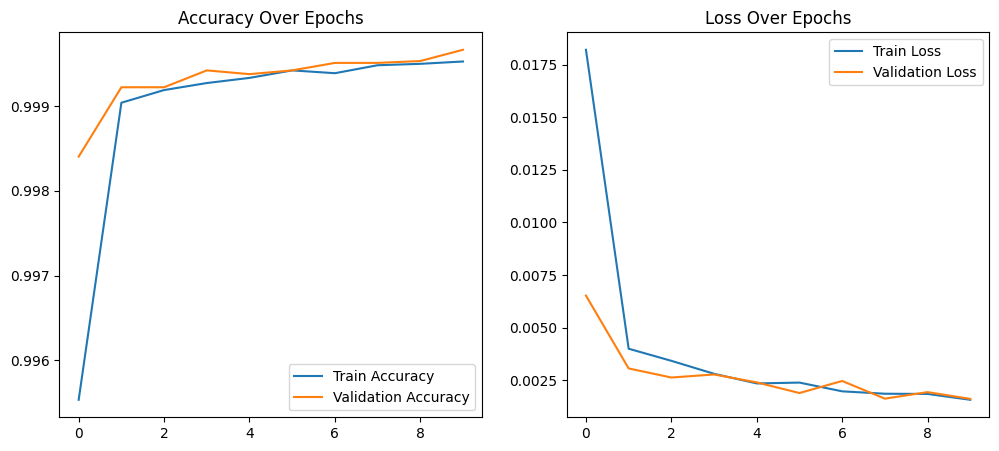

In [7]:
import matplotlib.pyplot as plt

# 🔹 Plot Training Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()